In [1]:
TRAIN = '/kaggle/input/retail-alcohol-detection-dataset/datasets/classification/dataset_1'

We want to use image embeddings for EDA and for classification, so let's add some code to get image embeddings from ResNeXt without fine-tuning.

In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 2048

model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 151MB/s]


Next let's load up our data, including image embeddings and thumbnails. We don't have a lot of data, so we can just load it all.

In [3]:
import arrow
import base64
import pandas as pd
from glob import iglob
from io import BytesIO
from os.path import basename
from PIL import Image

THUMBNAIL_SIZE = (64, 64)

def embed(model, filename: str):
    with Image.open(fp=filename, mode='r') as image:
        return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)


# https://stackoverflow.com/a/952952
def flatten(arg):
    return [x for xs in arg for x in xs]

def png(filename: str) -> str:
    with Image.open(fp=filename, mode='r') as image:
        buffer = BytesIO()
        # our images are pretty big; let's shrink the hover images to thumbnail size
        image.resize(size=THUMBNAIL_SIZE).convert('RGB').save(buffer, format='png')
        return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def get_picture_from_glob(arg: str, tag: str,) -> list:
    time_get = arrow.now()
    result = [pd.Series(data=[tag, basename(input_file), embed(model=model, filename=input_file), png(filename=input_file)],
                        index=['tag', 'name', 'value', 'png'] )
        for index, input_file in enumerate(list(iglob(pathname=arg))) ]
    print('encoded {} rows of {}  in {}'.format(len(result), tag, arrow.now() - time_get))
    return result

time_start = arrow.now()
train_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TRAIN + '/*') }
train_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in train_dict.items()]))
print('done in {}'.format(arrow.now() - time_start))

encoded 17 rows of Campari  in 0:00:02.342355
encoded 8 rows of Алтай  in 0:00:00.971551
encoded 17 rows of LЁN  in 0:00:02.289757
encoded 26 rows of Хаски  in 0:00:03.536559
encoded 31 rows of Талка  in 0:00:04.222598
encoded 11 rows of class_0005  in 0:00:01.429216
encoded 23 rows of Aperol  in 0:00:03.133556
encoded 66 rows of CinZano  in 0:00:08.606917
encoded 11 rows of Мамонт  in 0:00:01.526241
encoded 127 rows of Martini green  in 0:00:18.550952
encoded 102 rows of Martini red  in 0:00:14.571344
encoded 19 rows of Егермейстер  in 0:00:02.445418
encoded 23 rows of Тундра  in 0:00:02.985426
encoded 25 rows of Martini dark green  in 0:00:03.433538
encoded 104 rows of Русский стандарт  in 0:00:15.067315
encoded 38 rows of Пять озёр  in 0:00:04.935052
done in 0:01:30.108785


Our classes are unbalanced, but how unbalanced are they?

In [4]:
train_df['tag'].value_counts(normalize=True).to_frame().sort_values(by='proportion').T

tag            Алтай  class_0005    Мамонт   Campari       LЁN  Егермейстер  \
proportion  0.012346    0.016975  0.016975  0.026235  0.026235     0.029321   

tag           Aperol    Тундра  Martini dark green     Хаски    Талка  \
proportion  0.035494  0.035494             0.03858  0.040123  0.04784   

tag         Пять озёр   CinZano  Martini red  Русский стандарт  Martini green  
proportion   0.058642  0.101852     0.157407          0.160494       0.195988

We have some classes that are nearly twenty times the size of our smallest classes. This is not encouraging.

Let's use TSNE to add x/y coordinates based on our image embeddings.

In [5]:
from sklearn.manifold import TSNE

train_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
train_df[['x', 'y']] = train_reducer.fit_transform(X=train_df['value'].apply(func=pd.Series))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 648 samples in 0.003s...
[t-SNE] Computed neighbors for 648 samples in 0.115s...
[t-SNE] Computed conditional probabilities for sample 648 / 648
[t-SNE] Mean sigma: 4.867360
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.072624
[t-SNE] KL divergence after 1000 iterations: 0.484210


Now we're ready to plot. 

In [6]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.plotting import show
from bokeh.palettes import Turbo256
from bokeh.transform import factor_cmap

output_notebook()

datasource = ColumnDataSource(train_df[['png', 'tag', 'x', 'y']])
factor_count = max(train_df['tag'].nunique(), 3)
indices = np.linspace(0, len(Turbo256)-1, factor_count, dtype=int)
palette = [Turbo256[index] for index in indices]
mapper = factor_cmap(field_name = 'tag', palette=palette, factors=train_df['tag'].unique().tolist(), start=0, end=factor_count-1, )

plot_figure = figure(title='TSNE projection: Russian beverages', width=1000, height=800, tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@png' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 18px'>@tag</span>
    </div>
</div>
"""))

plot_figure.scatter(x='x', y='y', source=datasource, line_alpha=0.6, fill_alpha=0.6, size=8, color=mapper)
show(plot_figure)

Loading BokehJS ...

What do we see? Most of our classes are isolated. We have a few difficult cases, but for the most part our image embeddings look really good. Let's build a model and see what happens. 

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df['value'].apply(pd.Series), train_df['tag'], test_size=0.25, random_state=2025, stratify=train_df['tag'])
logreg = LogisticRegression(max_iter=5000, tol=1e-12).fit(X_train, y_train)
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y_test, y_pred=logreg.predict(X=X_test))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y_test, y_pred=logreg.predict(X=X_test))))
print(classification_report(y_true=y_test, y_pred=logreg.predict(X=X_test)))

model fit in 186 iterations
accuracy: 0.9815
f1: 0.9813
                    precision    recall  f1-score   support

            Aperol       1.00      1.00      1.00         6
           Campari       1.00      1.00      1.00         4
           CinZano       1.00      1.00      1.00        16
               LЁN       1.00      1.00      1.00         4
Martini dark green       0.83      0.83      0.83         6
     Martini green       0.97      0.97      0.97        32
       Martini red       1.00      1.00      1.00        25
        class_0005       1.00      1.00      1.00         3
             Алтай       1.00      1.00      1.00         2
       Егермейстер       1.00      1.00      1.00         5
            Мамонт       1.00      1.00      1.00         3
         Пять озёр       1.00      1.00      1.00        10
  Русский стандарт       0.96      1.00      0.98        26
             Талка       1.00      1.00      1.00         8
            Тундра       1.00      0.83    

Amazing. Except for Martini Dark Green our model has almost embarrassing accuracy. Let's take a look at our model probabilities. 

<Axes: xlabel='probability', ylabel='Count'>

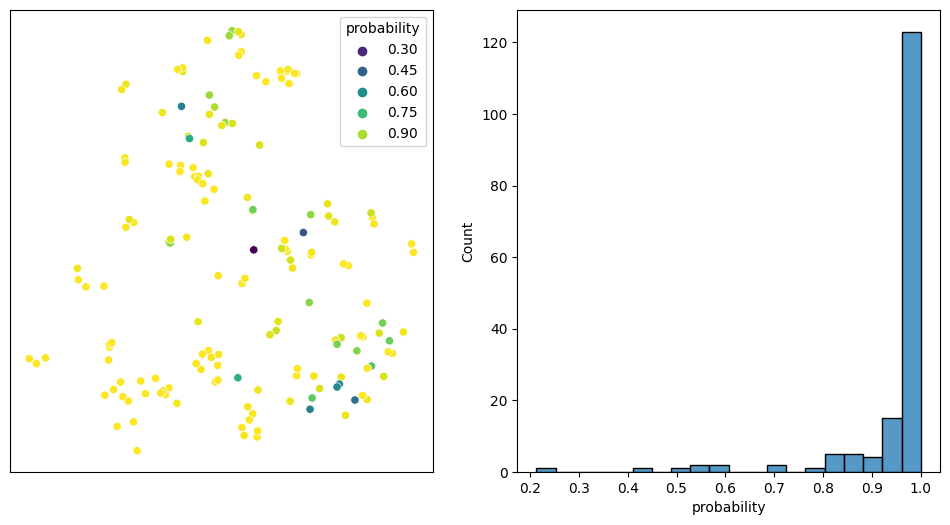

In [8]:
import matplotlib.pyplot as plt
import warnings
from seaborn import histplot
from seaborn import scatterplot

warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

plot_df = train_df.iloc[X_test.index][['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=X_test), axis=1)

plt, ax = plt.subplots(ncols=2, figsize=(12, 6))
scatterplot(ax=ax[0], data=plot_df, x='x', y='y', hue='probability', palette='viridis')
ax[0].set(xlabel=None) 
ax[0].set(ylabel=None)
ax[0].set(xticklabels=[])
ax[0].set(yticklabels=[])
ax[0].tick_params(axis='both', which='both', length=0)
histplot(ax=ax[1], data=plot_df, x='probability', bins=20)

Our model probabilities are mostly quite high; we have some difficult cases, and none of them are surprises.